In [1]:
# library preparations
import scipy.io
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import joblib
import seaborn as sns
import time

# Model Fitting

Given that we could just ask the simulation for more samples, I decided to NOT employ a typical training-split. Ratther, I will deploy all samples for training and optimize based on cross validation approaches, given every test record a turn at being in the training set and test set. Once the model is fitted, we can then ask the simulation for some more samples (say 1000) to use as a test set completely related here.

## Model Evaluations

Many metrics can be used to evaluate models, some I calculate here are:

1. Accuracy: TP + TN / total, this is the number of samples the RF model classifiers correctly
2. Error Rate: 1 - Accuracy, this is the number of samples the RF model classifiers incorrectly
3. True Positive Rate (TPR) | Sensitivity | Recall | Coverage: TP / (TP + FN), fraction of SAS examples correctly predicted
    + There's a typically a trade off between Recall and Precision below
4. True Negative Rate (TNR) | Specificity: TN / (FP + TN), fraction of neutral examples correctly predicted
5. False Positive Rate (FPR): FP / (FP + TN) fraction of neutral examples predicted as having SAS (really bad)
6. False Negative Rate (FNR): FN / (TP + FN) fraction of SAS examples predicted as having SAS (not as bad, but still bad)
7. Precision: TP / (TP + FP), fraction of samples that actually have SAS out of total samples predicted to have SAS
    + Precision addresses the question: "Given a sample predicted to have SAS, how likely is it to be correct?"
    + **We may want to sacrifice Recall in order to archieve a high precision**
8. F-measure: $\frac{2*precision*recall}{precision+recall}$, a harmonic mean (meaning the resulting metric is *closer to the smaller of the input, that is, F-measure is closer to either precision or recall, whichever is smaller in magnitude) of precision and recall
    + **Ideally, a F-measure should be high and indicate that both precision and recall are high**
9. Area under the Curve (AUC): this is the area of the curve under the Receiver operating characteristic (ROC) curve, which demonstrate the specificity-sensitivity trade-off (TPR vs TNR) 
    
## Confusion Matrix

<img src="./Images/matrix.png" alt="drawing" width="200">

## Alternative Metric: Cost Matrix

Sometimes, in the realm of health sciences, we want to *punish* or *reward* the model for doing something really well compared to other. For example, in cancer prediction, more emphasis is implaced on avoiding False Negatives (not detecting the cancer), so that we may wish to assign costs/weights (negative means reward) to TP, FP, TN, and FN like this:

<img src="./Images/cost_matrix.png" alt="drawing" width="200">

This can be implemented as other alternative to above metrics during cross validation. Or, cost matrix can be used to classify one particular record. That is, **we can use cost matrix to evaluate risk**

With a RandomForest, I am able to extract the *probability* of a sample as showing SAS or not, then say:

P(SAS) = 0.2
P(neutral, other) = 0.8

Given the above cost matrix, then when I:

* Classify this sample as having SAS, there's a 0.8 probability I am wrong, making a FP error with cost 1, or a risk of 0.8
* Classify this sample as not having SAS, there's a 0.2 probability I am wrong, making a FN error with cost 100, or a risk of 20
* I can then decide to classify this sample based on probability or this new risk factor

In [2]:
load_train = np.load('./data/train.npz', allow_pickle=True)
load_test = np.load('./data/test.npz', allow_pickle=True)
X_train, y_train = load_train['X_train'], load_train['y_train']
X_test, y_test = load_test['X_test'], load_test['y_test']

samples, rows, cols = X_train.shape
print("Before flattening:")
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

y_train = y_train.reshape(y_train.shape[0], )
y_test = y_test.reshape(y_test.shape[0], )
X_train = X_train.reshape(X_train.shape[0], -1)
X_test = X_test.reshape(X_test.shape[0], -1)

print("After flattening:")
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

Before flattening:
(6500, 460, 12)
(6500, 1)
(647, 460, 12)
(647, 1)
After flattening:
(6500, 5520)
(6500,)
(647, 5520)
(647,)


In [3]:
# Prepare for K fold cross validation
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import precision_score, recall_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score

k = 10
# again, random_state for sake of reproducibility
kf = KFold(n_splits=k, random_state = 42, shuffle=True)

# default confusion matrix 
# we can calculate TP, FP, FN, TN from this matrix at the end
matrix = pd.DataFrame(0, index=['True Yes', 'True No', ''], 
                      columns=['Pred Yes', 'Pred No', ''])

start = time.time()
for train_index, test_index in kf.split(X_train):
    # identify the train and test set within each fold
    X_fold_train, X_fold_test = X_train[train_index], X_train[test_index]
    y_fold_train, y_fold_test = y_train[train_index], y_train[test_index]
    
    # fit the model on the training set
    model = RandomForestClassifier(n_estimators=500, oob_score=True, 
                               min_samples_leaf = 10, max_depth = 5, 
                               min_samples_split = 100, max_leaf_nodes = 50,
                               max_features = 'sqrt', n_jobs=8)
    model.fit(X_fold_train, y_fold_train)

    # predict label on validation test set, record results
    y_pred = model.predict(X_fold_test)
    y_prob = model.predict_proba(X_fold_test)[:,1]

    # collect metrics
    m = pd.crosstab(y_pred, y_fold_test, margins=True)
    m.index = ['True Yes', 'True No', '']
    m.columns = ['Pred Yes', 'Pred No', '']
    matrix += m

end = time.time()
print('Time taken:', end - start)
print(matrix)
TP, FN = matrix.iloc[0, 0], matrix.iloc[0, 1]
FP, TN = matrix.iloc[1, 0], matrix.iloc[1, 1]
total = TP + FN + FP + TN
print("Accuracy: \t\t\t\t\t\t\t", (TP + TN) / total)
print("Error Rate: \t\t\t\t\t\t\t", (FN + FP) / total)
recall = TP / (TP + FN)
print("True Positive Rate (TPR) | Sensitivity | Recall | Coverage\t", recall)
print("True Negative Rate (TNR) | Specificity \t\t\t\t", 
      TN / (FP + TN))
print("False Positive Rate (FPR) is \t\t\t\t\t", FP / (FP + TN))
print("False Negative Rate (FNR) is \t\t\t\t\t", FN / (TP + FN))
precision = TP / (TP + FP)
print("Average Precision: \t\t\t\t\t\t", precision)
print("Average Recall: \t\t\t\t\t\t", recall)
print("Average F Measures: \t\t\t\t\t\t", 
      (2*precision*recall) / (precision+recall))
pred_prob = model.predict_proba(X_train)[:, 1]
print("Average AUC: \t\t\t\t\t\t\t", roc_auc_score(y_train, pred_prob))

Time taken: 92.98476338386536
          Pred Yes  Pred No      
True Yes      1986      175  2161
True No        459     3880  4339
              2445     4055  6500
Accuracy: 							 0.9024615384615384
Error Rate: 							 0.09753846153846153
True Positive Rate (TPR) | Sensitivity | Recall | Coverage	 0.9190189726978251
True Negative Rate (TNR) | Specificity 				 0.8942152569716525
False Positive Rate (FPR) is 					 0.10578474302834755
False Negative Rate (FNR) is 					 0.08098102730217492
Average Precision: 						 0.8122699386503067
Average Recall: 						 0.9190189726978251
Average F Measures: 						 0.8623534520191055
Average AUC: 							 0.9835690745097447


In [4]:
# https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html
# n_estimators = number of trees to bag
# Fit the model on all training samples possible
# clf = RandomForestClassifier(n_estimators=500, criterion='gini', max_depth=None, 
#                         min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, 
#                         max_features='auto', max_leaf_nodes=None, min_impurity_decrease=0.0, 
#                         min_impurity_split=None, bootstrap=True, oob_score=False, n_jobs=None, 
#                         random_state=None, verbose=0, warm_start=False, class_weight=None, 
#                         ccp_alpha=0.0, max_samples=None)
# Tune: min_samples_split, max_leaf_nodes, max_depth and min_samples_leaf.
model = RandomForestClassifier(n_estimators=500, oob_score=True, 
                               min_samples_leaf = 10, max_depth = 5, 
                               min_samples_split = 100, max_leaf_nodes = 50,
                               max_features = 'sqrt', n_jobs=8)

start = time.time()
model.fit(X_train, y_train)
end = time.time()
print('Time taken:', end - start)

# save the model
joblib.dump(model, "./data/random_forest_10000.joblib")

Time taken: 9.560846090316772


['./data/random_forest_10000.joblib']

Feature pi_x importance: 8.164764516235056e-05 						
Feature pi_y importance: 0.004462907796602058 						
Feature Pi_tot importance: 0.00020357002901359443 						
Feature Fst importance: 0.00045011389855475353 						
Feature Dxy importance: 0.00029200785282084525 						
Feature Da importance: 0.0004025598252616499 						
Feature Tajima's D on X importance: 8.83188273904177e-05 						
Feature Tajima's D on Y importance: 0.000749645627311387 						
Feature Tajima's D across all samples importance: 0.00042798755529840704 						
Feature SNP rel. dens. on X importance: 0.009293695994424778 						
Feature SNP rel. dens. on Y importance: 0.016074740674935393 						
Feature SNP rel. dens. across all importance: 0.010707318979558811 						


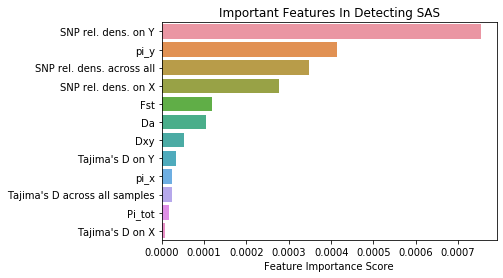

In [10]:
features_index = ["pi_x", "pi_y", "Pi_tot", "Fst", "Dxy", "Da", "Tajima's D on X", 
 "Tajima's D on Y", "Tajima's D across all samples", "SNP rel. dens. on X",
 "SNP rel. dens. on Y", "SNP rel. dens. across all"]

for f, imp in zip(features_index, model.feature_importances_):
    print(f'Feature {f} importance: {imp} \t\t\t\t\t\t')

features = model.feature_importances_.reshape(rows, cols).mean(axis=0)
feature_imp = pd.Series(features,index=features_index).sort_values(
    ascending=False)

%matplotlib inline
# Creating a bar plot
sns.barplot(x=feature_imp, y=feature_imp.index)
# Add labels to your graph
plt.xlabel('Feature Importance Score')
plt.title("Important Features In Detecting SAS")
plt.show()

In [6]:
# Extract single tree
estimator = model.estimators_[5]

from sklearn.tree import export_graphviz
# Export as dot file
export_graphviz(estimator, out_file='tree.dot', 
                feature_names = features_index * rows,
                class_names = ["SAS", "Neutral"],
                rounded = True, proportion = False, 
                precision = 2, filled = True)

# Convert to png using system command (requires Graphviz)
from subprocess import call
call(['dot', '-Tpng', 'tree.dot', '-o', 'tree.png', '-Gdpi=600'])

# Display in jupyter notebook
from IPython.display import Image
Image(filename = 'tree.png')

## Test Set Evaluation

Below are peformance measures on the test set never touched during model building

In [7]:
y_pred = model.predict(X_test)
print("Accuracy on Test Set:", accuracy_score(y_test,y_pred))
print(f'Our OOB prediction of accuracy is: {model.oob_score_ * 100}%')

# show stats
matrix = pd.crosstab(y_pred, y_test, margins=True)
matrix.index = ['True Yes', 'True No', '']
matrix.columns = ['Pred Yes', 'Pred No', '']
print(matrix)

TP, FN = matrix.iloc[0, 0], matrix.iloc[0, 1]
FP, TN = matrix.iloc[1, 0], matrix.iloc[1, 1]
total = TP + FN + FP + TN
print("Accuracy: \t\t\t\t\t\t\t", (TP + TN) / total)
print("Error Rate: \t\t\t\t\t\t\t", (FN + FP) / total)
print("True Positive Rate (TPR) | Sensitivity | Recall | Coverage\t", 
      TP / (TP + FN))
print("True Negative Rate (TNR) | Specificity \t\t\t\t", 
      TN / (FP + TN))
print("False Positive Rate (FPR) is \t\t\t\t\t", FP / (FP + TN))
print("False Negative Rate (FNR) is \t\t\t\t\t", FN / (TP + FN))
precision = TP / (TP + FP)
recall = TP / (TP + FN)
print("Average Precision: \t\t\t\t\t\t", precision)
print("Average F Measures: \t\t\t\t\t\t", 
      (2*recall*precision) / (recall + precision))
pred_prob = model.predict_proba(X_test)[:, 1]
print("Average AUC: \t\t\t\t\t\t\t", roc_auc_score(y_test, pred_prob))

Accuracy on Test Set: 0.5811437403400309
Our OOB prediction of accuracy is: 90.06153846153846%
          Pred Yes  Pred No     
True Yes        45      181  226
True No         90      331  421
               135      512  647
Accuracy: 							 0.5811437403400309
Error Rate: 							 0.4188562596599691
True Positive Rate (TPR) | Sensitivity | Recall | Coverage	 0.19911504424778761
True Negative Rate (TNR) | Specificity 				 0.7862232779097387
False Positive Rate (FPR) is 					 0.21377672209026127
False Negative Rate (FNR) is 					 0.8008849557522124
Average Precision: 						 0.3333333333333333
Average F Measures: 						 0.24930747922437668
Average AUC: 							 0.4837528935185186


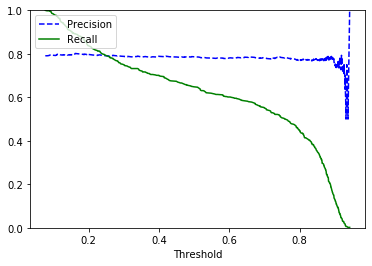

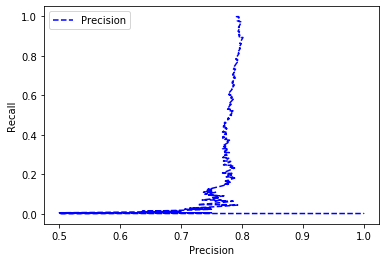

In [8]:
from sklearn.metrics import precision_recall_curve

# precision recall curve for training set 
y_prob = model.predict_proba(X_test)[:,1]
precisions, recalls, thresholds = precision_recall_curve(
    y_test, y_prob, pos_label = "Yes")

def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.xlabel("Threshold")
    plt.legend(loc="upper left")
    plt.ylim([0, 1])

plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

plt.plot(precisions, recalls, "b--", label="Precision")
plt.xlabel("Precision")
plt.ylabel("Recall")
plt.legend(loc="upper left")
plt.show()

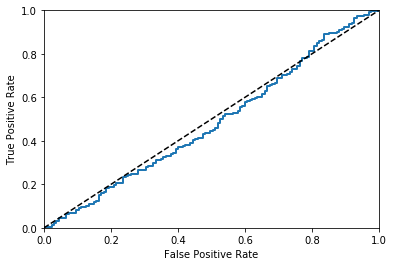

The AUC is  0.4837528935185186


In [9]:
# ROC Curve
# The more the area under the curve the better our classifier
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_test, y_prob, pos_label = "Yes")
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')

plot_roc_curve(fpr, tpr, "Random Forest")
plt.show()

from sklearn.metrics import roc_auc_score
print("The AUC is ", roc_auc_score(y_test, y_prob))

Next steps:

Generating a diversity of inputs:

* 0.5 vs 0.5 allele frequency that produce similar patterns to SAS but is not SAS

Transfer of knowledge:

* Use existing model to predict on 0.5 vs 0.5 cases, see what prediction results we obtain

Build the same model using alt_output (means)

Remaining issues:

1. Presence of NaNs and Infs
    + 3210 samples have NaNs sproadically throughout all features
    + 731 samples have Infs only for feature 7: (Tajima's D on the Y)
2. How to generate a diverse, well-rounded dataset covering all scenarios possible?
    + Start playing with more complex cases, incorporation of 0.5 vs 0.5 allele frequency
3. Fine tuning the model to archieve better results: Strong Overfitting and Poor Generalizability
    + Reasons for a high generalization gap:
        + Different distributions: The validation and test set might come from different distributions. Try to verify that they are indeed sampled from the same process in your code.
        + Number of samples: The size of the validation and / or the test set is too low. This means that the empirical data distributions differ too much, explaining the different reported accuracies. One example would be a dataset consisting of thousands of images, but also thousands of classes. Then, the test set might contain some classes that are not in the validation set (and vice versa). Use cross-validation to check, if the test accuracy is always lower than the validation accuracy, or if they just generally differ a lot in each fold.
        + Hyperparameter Overfitting: This is also related to the size of the two sets. Did you do hyperparameter tuning? If so, you can check if the accuracy gap existed before you tuned the hyperparameters, as you might have "overfitted" the hyperparameters on the validation set.
        + Loss function vs. accuracy: you reported different accuracies. Did you also check the train, validation and test losses? You train your model on the loss function, so this is the most direct performance measure. If the accuracy is only loosely coupled to your loss function and the test loss is approximately as low as the validation loss, it might explain the accuracy gap.
        + Bug in the code: if the test and validation set are sampled from the same process and are sufficiently large, they are interchangeable. This means that the test and validation losses must be approximately equal. So, if you checked the four points above, my next best guess would be a bug in the code. For example, you accidentally trained your model on the validation set as well. You might want to train your model on a larger dataset and then check, if the accuracies still diverge.
        + **What I think: Test set too small**
    + What metric do we want to use? (see modeling section for full list of possible metrics)
4. Speeding up Scripts on TACC
    + 13 hour run time to generate 2000 samples using 1 node, long